In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from matplotlib.colors import LogNorm

## Constants

In [2]:
DATA_PATH   = "./data"
DATA_PREFIX = "beam-analysis-day"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

## Read data

In [28]:
run_day  = 2

data_labr_a = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_labr_b = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_B))

data_clyc = pd.read_csv(f"{DATA_PATH}/data_clyc_with_cluster.csv", sep=',')

In [29]:
# clean data from saturated events
data_labr_a = data_labr_a[data_labr_a["energy"] < data_labr_a["energy"].max()]
data_labr_b = data_labr_b[data_labr_b["energy"] < data_labr_b["energy"].max()]

# clean data from zero energy events
data_labr_a = data_labr_a[data_labr_a["energy"] > 0]
data_labr_b = data_labr_b[data_labr_b["energy"] > 0]

## Calibration

In [30]:
param_labr_a = read_calibration_parameters(
    "./calibration-parameters/labr_a_linear_parameters.txt"
)

param_labr_b = read_calibration_parameters(
    "./calibration-parameters/labr_b_linear_parameters.txt"
)

In [31]:
data_labr_a.loc[:, "energy_calib"]       = linear_calibration(data_labr_a["energy"], param_labr_a)
data_labr_a.loc[:, "energy_short_calib"] = linear_calibration(data_labr_a["energy_short"], param_labr_a)

data_labr_b.loc[:, "energy_calib"]       = linear_calibration(data_labr_b["energy"], param_labr_b)
data_labr_b.loc[:, "energy_short_calib"] = linear_calibration(data_labr_b["energy_short"], param_labr_b)

In [32]:
def compute_psd(df):
    return (df["energy"] - df["energy_short"]) / df["energy"]

def compute_psd_calib(df):
    return (df["energy_calib"] - df["energy_short_calib"]) / df["energy_calib"]

data_labr_a.loc[:, "psd"] = compute_psd(data_labr_a)
data_labr_b.loc[:, "psd"] = compute_psd(data_labr_b)
data_labr_a.loc[:, "psd_calib"] = compute_psd_calib(data_labr_a)
data_labr_b.loc[:, "psd_calib"] = compute_psd_calib(data_labr_b)

In [33]:
# remove all points that have a psd or psd_calib value greater than 1
def remove_psd_outliers(df):
    return df[(df["psd"] < 1) & (df["psd_calib"] < 1)]

data_labr_a = remove_psd_outliers(data_labr_a)
data_labr_b = remove_psd_outliers(data_labr_b)

In [34]:
# add an ID column to the dataframes that ranges from 0 to the number of events
data_labr_a.loc[:, "id"] = np.arange(len(data_labr_a))
data_labr_b.loc[:, "id"] = np.arange(len(data_labr_b))

## CLYC PID CHECK

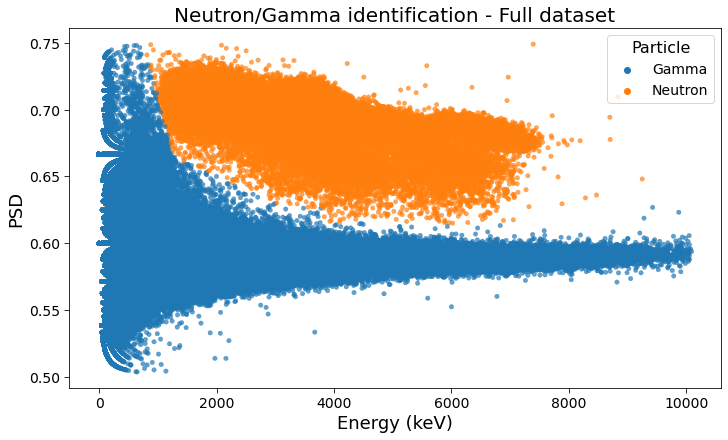

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

sns.scatterplot(x='energy_calib', y='psd', hue='Particle', data=data_clyc, palette="tab10", alpha=0.7, edgecolor=None, ax=ax, s=20, legend=True)


ax.set_title('Neutron/Gamma identification - Full dataset', fontsize=20)
ax.set_xlabel('Energy (keV)', fontsize=18)
ax.set_ylabel('PSD', fontsize=18)


ax.tick_params(axis="both", which="major", labelsize=14, length=5)

ax.legend(fontsize=14, title_fontsize=16, title="Particle", loc="upper right")


plt.show()

## COINCIDENCE

In [35]:
# select neutrons from the clyc data
clyc_neutrons = data_clyc[data_clyc["Particle"] == "Neutron"]

clyc_neutrons.shape

(73473, 12)

In [12]:
clyc_neutrons.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
6,1,2,16384,12612716702,827,252,4157.534177,1246.141772,0.695284,0.700269,6,Neutron
27,1,2,16384,106771166842,592,176,2967.660759,861.331646,0.702703,0.709761,28,Neutron
41,1,2,16384,150690123717,625,185,3134.749367,906.901266,0.704000,0.710694,43,Neutron
57,1,2,16384,210063427874,750,221,3767.660759,1089.179747,0.705333,0.710914,59,Neutron
68,1,2,16384,236032881483,580,171,2906.901266,836.015190,0.705172,0.712403,71,Neutron


In [13]:
data_labr_a.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id
0,1,1,16384,588231592,38,37,137.830638,134.525656,0.026316,0.023979,0
1,1,1,16384,4164935275,464,462,1545.752959,1539.142995,0.004310,0.004276,1
2,1,1,16384,6362520756,390,389,1301.184293,1297.879311,0.002564,0.002540,2
3,1,1,16384,7666449859,278,277,931.026311,927.721329,0.003597,0.003550,3
4,1,1,16384,8014917359,82,81,283.249844,279.944862,0.012195,0.011668,4


### LaBr3 A

In [14]:
# add a PArticle column to the labr data with the value "Gamma" for all events
data_labr_a.loc[:, "Particle"] = "Gamma"

In [15]:
import pandas as pd

# Create an empty dataframe to store the rows that match the criteria
result_a = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])

def check_timestamps_a(row):
    global result_a
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_a['timestamp'] >= timestamp - 50000000) & (data_labr_a['timestamp'] <= timestamp + 50000000)
    matching_rows = data_labr_a[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_a = result_a.append(row, ignore_index=True)
        result_a = result_a.append(matching_rows, ignore_index=True)

# Use the apply method to iterate through the rows of the clyc_neutrons dataframe and check for matching timestamps
clyc_neutrons.apply(check_timestamps_a, axis=1)


6          None
27         None
41         None
57         None
68         None
           ... 
1983450    None
1983454    None
1983592    None
1983625    None
1983642    None
Length: 73473, dtype: object

In [16]:
result_a

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,2,16384,1767936733420,645,190,3236.015190,932.217722,0.705426,0.711924,496,Neutron
1,1,1,16384,1767948916951,91,90,312.994682,309.689700,0.010989,0.010559,1146,Gamma
2,1,2,16384,2333175639936,376,106,1873.989873,506.901266,0.718085,0.729507,641,Neutron
3,1,1,16384,2333175619718,62,62,217.150205,217.150205,0.000000,0.000000,1546,Gamma
4,1,2,16384,2788429711147,1011,313,5089.179747,1555.002532,0.690406,0.694449,765,Neutron
...,...,...,...,...,...,...,...,...,...,...,...,...
10344,1,1,16384,7611761365078466,149,148,504.683637,501.378655,0.006711,0.006549,5186757,Gamma
10345,1,2,16384,7613653892041873,434,131,2167.660759,633.483544,0.698157,0.707757,2163349,Neutron
10346,1,1,16384,7613653845940983,55,55,194.015331,194.015331,0.000000,0.000000,5188054,Gamma
10347,1,2,16384,7614283917573748,675,194,3387.913924,952.470886,0.712593,0.718862,2163520,Neutron


In [17]:
# save coincidence data to a csv file
# result_a.to_csv(f"{DATA_PATH}/labra-coincidence.csv", index=False)

### LaBr3 B

In [36]:
# add a PArticle column to the labr data with the value "Gamma" for all events
data_labr_b.loc[:, "Particle"] = "Gamma"

In [37]:
data_labr_b

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,0,16384,1338336054,479,478,1699.336955,1695.814756,0.002088,0.002073,0,Gamma
1,1,0,16384,2100133451,134,134,484.178546,484.178546,0.000000,0.000000,1,Gamma
2,1,0,16384,2647624905,109,109,396.123589,396.123589,0.000000,0.000000,2,Gamma
3,1,0,16384,3519642186,110,110,399.645787,399.645787,0.000000,0.000000,3,Gamma
4,1,0,16384,4142370045,141,140,508.833934,505.311736,0.007092,0.006922,4,Gamma
...,...,...,...,...,...,...,...,...,...,...,...,...
4228368,1,0,16384,7615255341595061,75,75,276.368847,276.368847,0.000000,0.000000,4203730,Gamma
4228369,1,0,16384,7615258426940225,276,275,984.330703,980.808504,0.003623,0.003578,4203731,Gamma
4228370,1,0,16384,7615259466112803,249,249,889.231349,889.231349,0.000000,0.000000,4203732,Gamma
4228371,1,0,16384,7615260072699498,76,76,279.891046,279.891046,0.000000,0.000000,4203733,Gamma


In [45]:
# Create an empty dataframe to store the rows that match the criteria
result_b = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])

def check_timestamps_b(row):
    global result_b
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_b['timestamp'] >= timestamp - 50000000) & (data_labr_b['timestamp'] <= timestamp + 50000000)
    matching_rows = data_labr_b[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_b = result_b.append(row, ignore_index=True)
        result_b = result_b.append(matching_rows, ignore_index=True)

# Use the apply method to iterate through the rows of the clyc_neutrons dataframe and check for matching timestamps
clyc_neutrons.apply(check_timestamps_b, axis=1)


6          None
27         None
41         None
57         None
68         None
           ... 
1983450    None
1983454    None
1983592    None
1983625    None
1983642    None
Length: 73473, dtype: object

In [46]:
result_b

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,2,16384,487556196139,570,181,2856.268354,886.648101,0.682456,0.689578,152,Neutron
1,1,0,16384,487581891294,211,211,755.387814,755.387814,0.000000,0.000000,243,Gamma
2,1,2,16384,1211581046218,604,185,3028.420253,906.901266,0.693709,0.700537,344,Neutron
3,1,0,16384,1211581045580,670,669,2372.076827,2368.554629,0.001493,0.001485,676,Gamma
4,1,2,16384,2325577565881,1258,394,6339.812658,1965.129114,0.686804,0.690034,639,Neutron
...,...,...,...,...,...,...,...,...,...,...,...,...
8006,1,0,16384,7612223206485562,138,138,498.267339,498.267339,0.000000,0.000000,4202011,Gamma
8007,1,2,16384,7612358253169061,286,83,1418.293671,390.445570,0.709790,0.724708,2162978,Neutron
8008,1,0,16384,7612358245838725,303,303,1079.430056,1079.430056,0.000000,0.000000,4202090,Gamma
8009,1,2,16384,7614357512066906,363,109,1808.167089,522.091139,0.699725,0.711259,2163540,Neutron


In [47]:
# save coincidence data to a csv file
result_b.to_csv(f"{DATA_PATH}/labrb-coincidence.csv", index=False)

In [54]:
# time windows (in picoseconds) to check for coincidences
time_windows = [50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000]


### LABR A ###
def check_timestamps_a(row, tw):
    global result_a
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_a['timestamp'] >= timestamp - tw//2) & (data_labr_a['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_a[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_a = result_a.append(row, ignore_index=True)
        result_a = result_a.append(matching_rows, ignore_index=True)
        
        
### LABR B ###
def check_timestamps_b(row, tw):
    global result_b
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_b['timestamp'] >= timestamp - tw//2) & (data_labr_b['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_b[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_b = result_b.append(row, ignore_index=True)
        result_b = result_b.append(matching_rows, ignore_index=True)
        
# Loop through the time windows and check for coincidences
for tw in time_windows:
    
    print(f"Checking for coincidences within {tw/1000} nanoseconds...")
    
    
    result_a = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_a, axis=1, args=(tw,))
    
    print(f"Found {len(result_a)} coincidences within {tw/1000} nanoseconds.")
    result_a.to_csv(f"{DATA_PATH}/labra-coincidence-{tw/1000}ns.csv", index=False)
    
    result_b = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_b, axis=1, args=(tw,))
    
    print(f"Found {len(result_b)} coincidences within {tw/1000} nanoseconds.")
    result_b.to_csv(f"{DATA_PATH}/labrb-coincidence-{tw/1000}ns.csv", index=False)
    
    
    print(f"Done checking for coincidences within {tw/1000} nanoseconds.")
    

Checking for coincidences within 50.0 nanoseconds...
Found 618 coincidences within 50.0 nanoseconds.
Found 168 coincidences within 50.0 nanoseconds.
Done checking for coincidences within 50.0 nanoseconds.
Checking for coincidences within 100.0 nanoseconds...
Found 632 coincidences within 100.0 nanoseconds.
Found 174 coincidences within 100.0 nanoseconds.
Done checking for coincidences within 100.0 nanoseconds.
Checking for coincidences within 500.0 nanoseconds...
Found 664 coincidences within 500.0 nanoseconds.
Found 206 coincidences within 500.0 nanoseconds.
Done checking for coincidences within 500.0 nanoseconds.
Checking for coincidences within 1000.0 nanoseconds...
Found 706 coincidences within 1000.0 nanoseconds.
Found 256 coincidences within 1000.0 nanoseconds.
Done checking for coincidences within 1000.0 nanoseconds.
Checking for coincidences within 5000.0 nanoseconds...
Found 1126 coincidences within 5000.0 nanoseconds.
Found 582 coincidences within 5000.0 nanoseconds.
Done che

In [55]:
# read in the coincidence data
test = pd.read_csv(f"{DATA_PATH}/labra-coincidence-50.0ns.csv")
test

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,2,16384,2333175639936,376,106,1873.989873,506.901266,0.718085,0.729507,641,Neutron
1,1,1,16384,2333175619718,62,62,217.150205,217.150205,0.000000,0.000000,1546,NaN
2,1,2,16384,78699709956874,903,282,4542.344304,1398.040506,0.687708,0.692220,21150,Neutron
3,1,1,16384,78699709965328,88,88,303.079736,303.079736,0.000000,0.000000,51189,NaN
4,1,2,16384,126234206747779,570,169,2856.268354,825.888608,0.703509,0.710850,33998,Neutron
...,...,...,...,...,...,...,...,...,...,...,...,...
613,1,1,16384,7578015798779248,76,76,263.419953,263.419953,0.000000,0.000000,5163195,NaN
614,1,2,16384,7585705178544139,525,169,2628.420253,825.888608,0.678095,0.685785,2155147,Neutron
615,1,1,16384,7585705178546529,111,111,379.094322,379.094322,0.000000,0.000000,5168583,NaN
616,1,2,16384,7601180397269022,789,262,3965.129114,1296.774684,0.667934,0.672955,2159685,Neutron
